In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Fri Jul 12 17:19:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:03:00.0  On |                  N/A |
| 62%   79C    P2             101W / 250W |   1827MiB / 11264MiB |     27%      D

In [2]:
# Install necessary packages (Kaggle-> CUDA Version: 11.0 | Colab-> CUDA Version: 11.2).
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
!pip install wandb --upgrade     

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 807.7 kB/s eta 0:00:000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 1.9 MB/s eta 0:00:0000:0100:01m
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached pillow-10.4.0-cp38-cp38-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
Using cached pillow-10.4.0-cp38-cp38-manylinux_2_28_x86_64.whl (4.5 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 334.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44088 sha256=a6f7b114d7e98a4bc06ac7f9ea7a5ec2ae715340ad6d2bbf3eba47a7b753e4ab
  Stored in directory: /mnt/DATA/NITWPHD/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8

In [3]:
# Check installed packages:
from termcolor import colored

import torch
assert torch.__version__ == '1.7.1+cu110', f' Torch version is: {torch.__version__}'
print(colored(f' Torch version is: {torch.__version__}', 'green', attrs=['bold'])) 

import torchvision
assert torchvision.__version__ == '0.8.2+cu110', f'Torchvision version is: {torchvision.__version__}' 
print(colored(f' Torchvision version is: {torchvision.__version__}', 'green', attrs=['bold'])) 

import detectron2
assert detectron2.__version__ == '0.5', f' Detectron2 version is: {detectron2.__version__}' 
print(colored(f' Detectron2 version is: {detectron2.__version__}', 'green', attrs=['bold'])) 

 Torch version is: 1.7.1+cu110
 Torchvision version is: 0.8.2+cu110
 Detectron2 version is: 0.5


/mnt/DATA/NITWPHD/anaconda3/envs/fasterRCNN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Check GPU properties:
if torch.cuda.is_available():
    gpu = !nvidia-smi -L 
    gpu_name_and_id = ''.join(gpu[0].split(':')[1:])
    print(colored('This notebook uses a GPU' + gpu_name_and_id, 'green', attrs=['bold']))
else:
    print(colored('No GPU available','red', attrs=['bold']))

This notebook uses a GPU NVIDIA GeForce RTX 2080 Ti (UUID GPU-d1406f78-ad1c-2687-fe6a-6eb88d988649)


In [5]:
# Import necessary detectron2 utilities:
import detectron2
from detectron2 import model_zoo

from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, hooks, launch
from detectron2.engine.hooks import HookBase

from detectron2.config import get_cfg
from detectron2.config.config import CfgNode as CN

from detectron2.utils.visualizer import Visualizer, ColorMode 
from detectron2.utils.logger import setup_logger, log_every_n_seconds, logging 
import detectron2.utils.comm as comm

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.data.detection_utils import transform_instance_annotations
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

from detectron2.evaluation import COCOEvaluator, RotatedCOCOEvaluator, inference_on_dataset, inference_context

from detectron2.modeling import build_model

from detectron2.structures.boxes import BoxMode

from detectron2.checkpoint import DetectionCheckpointer

setup_logger() # Setup detectron2 logger

AttributeError: module 'PIL.Image' has no attribute 'LINEAR'

In [4]:
# Import some common libraries:
import numpy as np
import PIL
import pandas as pd
import random
import yaml 
import os, json, matplotlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import time
import datetime
import pytz
import copy
import math

# Load and register Train, Test and Validation sets.

In [5]:
# If u are using google colab run this:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset_dir = '/content/drive/MyDrive/Datasets/HRSID'

In [63]:
def register_COCO_datasets(dataset_dir):

    """Loads, registers and names the 3 parts (Train, Test and Validation) of 
    the dataset from the given directory. Every time that the specific function 
    is called it creates a unique name for each one of Train, Test and Validation
    sets, because detectron2 can't register a previous registered dataset with 
    the same dataset name.

    Args:
        dataset_dir (str): Dataset's directory.

    Returns:
        dataset_names (list): A list of train, test and validation set names.

    """
    _, SubFolders, _ = next(os.walk(dataset_dir))
    SubFolders.sort()
    
    # Subfolder check.
    SubFoldrs =[]
    for folder_name in SubFolders:
        if 'set' in folder_name: SubFoldrs.append(folder_name)     

    rint = str(random.randint(0, 1000))
    Setnames = ['Training','Validation','Test']
    dataset_names = []

    for folder_name, setname in zip(SubFoldrs, Setnames):
        files_dir = os.path.join(dataset_dir, folder_name, 'data')
        json_dir = os.path.join(dataset_dir, folder_name, 'labels.json')
        dataset_name = 'HRSID' + '_' + setname + '_' + rint
        register_coco_instances(dataset_name, {}, json_dir, files_dir)
        dataset_names.append(dataset_name)
    
    print(colored(f'Datasets: {dataset_names[0]}, {dataset_names[1]}, {dataset_names[2]} Registered successfully!','green', attrs=['bold']))

    return dataset_names

In [8]:
def extract_sets_id(dataset_names):

    """Extracts the id of each one of the three sets (Training, Test and 
    Validation) and uses it as id for accesing the specific dataset.

    Args:
        dataset_names (list): A list of train, test and validation set names.

    Returns:
        train_id (int): The id of the train set.
        train_id (int): The id of the test set.
        train_id (int): The id of the validation set.

    """
    train_id, test_id, valid_id = 99,99,99

    for i, dataset_name in enumerate(dataset_names):
        if dataset_name.split('_')[1] == 'Training': 
            train_id = i
        elif dataset_name.split('_')[1] == 'Test':
            test_id = i
        else:
            valid_id = i

    return train_id, valid_id, test_id        

In [9]:
dataset_names = register_COCO_datasets(dataset_dir)
train_id, val_id, test_id = extract_sets_id(dataset_names)

Datasets: HRSID_Training_474, HRSID_Validation_474, HRSID_Test_474 Registered successfully!


In [10]:
#Get dicts and metadata from train data.
dicts_train = detectron2.data.get_detection_dataset_dicts(dataset_names[train_id])
metadata_train = MetadataCatalog.get(dataset_names[train_id])
metadata_train.thing_colors = [(0, 255, 0)] #255 165 0 

#Get dicts and metadata from validation data.
dicts_val = detectron2.data.get_detection_dataset_dicts(dataset_names[val_id])
metadata_val = MetadataCatalog.get(dataset_names[val_id])
metadata_val.thing_colors = [(0, 255, 0)]

#Get dicts and metadata from test data.
dicts_test = detectron2.data.get_detection_dataset_dicts(dataset_names[test_id])
metadata_test = MetadataCatalog.get(dataset_names[test_id])
metadata_test.thing_colors = [(0, 255, 0)]

[04/27 12:39:47 d2.data.datasets.coco]: Loaded 3461 images in COCO format from /content/drive/MyDrive/Datasets/HRSID/temp_train_set/labels.json
[04/27 12:39:48 d2.data.build]: Removed 0 images with no usable annotations. 3461 images left.
[04/27 12:39:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 10529        |
|            |              |
[04/27 12:39:48 d2.data.datasets.coco]: Loaded 256 images in COCO format from /content/drive/MyDrive/Datasets/HRSID/temp_val_set/labels.json
[04/27 12:39:48 d2.data.build]: Removed 0 images with no usable annotations. 256 images left.
[04/27 12:39:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 828          |
|            |              |
[04/27 12:39:50 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Datasets/HRSID/test_set/labels.json takes 1.17 seco

In [11]:
# Check the class names of the training and validation set. 
assert metadata_test.thing_classes == metadata_train.thing_classes == metadata_val.thing_classes
print(f'Class names in Training set: {metadata_train.thing_classes}')
print(f'Class names in Validation set: {metadata_val.thing_classes}')
print(f'Class names in Test set: {metadata_test.thing_classes}')

Class names in Training set: ['ship']
Class names in Validation set: ['ship']
Class names in Test set: ['ship']


# **Display some random training images.**

In [12]:
def show_rand_img(dicts, metadata, img_id=None):

    """Selects an image from the given set and displays it with its 
    annotations.

    Args:
        dicts (list): List of dataset's dictionaries.
        metadata (detectron2.data.catalog.Metadata): Dataset's metadata.
        img_id(int): Image id for display.
        
    """
    image_dicts = []
    
    if img_id is not None:
        for i,props in enumerate(dicts):
            if props['image_id'] == img_id:
                image_dicts = dicts[i]
            random_image_properties = image_dicts  
        if random_image_properties==[]:
            print(f'The requested image id it is not contained in the {metadata.name} set...')
            print('A random image will be selected for visualization...')

            #Select a random image from the given set and extract its properties.
            random_im_number = random.randint(0, len(dicts)) 
            random_image_properties = dicts[random_im_number]
            
    else:
        #Select a random image from the given set and extract its properties.
        random_im_number = random.randint(0, len(dicts)) 
        random_image_properties = dicts[random_im_number]

    #Read image path.
    path = random_image_properties['file_name']
    set_name = metadata.name

    #Read image and add propeties.
    random_image_4_viz = cv2.imread(path) 
    
    #Print image id.
    cv2.putText(
        random_image_4_viz, #numpy array on which text is written
        'Image ID: ' +  str(random_image_properties['image_id']), #text
        (670, 770), #position at which writing has to start
        cv2.FONT_HERSHEY_SIMPLEX, #font family
        0.4, #font size
        (255, 0, 0, 0), #font color BGR
        1) #font stroke
    
    #Print set name.
    cv2.putText(random_image_4_viz, set_name, 
                (670,790), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0, 0), 1) 

    #Visualize the selected image together with its annotations.
    viz = Visualizer(random_image_4_viz, metadata=metadata, scale=1., instance_mode=ColorMode.SEGMENTATION)
    out = viz.draw_dataset_dict(random_image_properties)
   
    plt.figure(figsize=(16,16))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out.get_image())

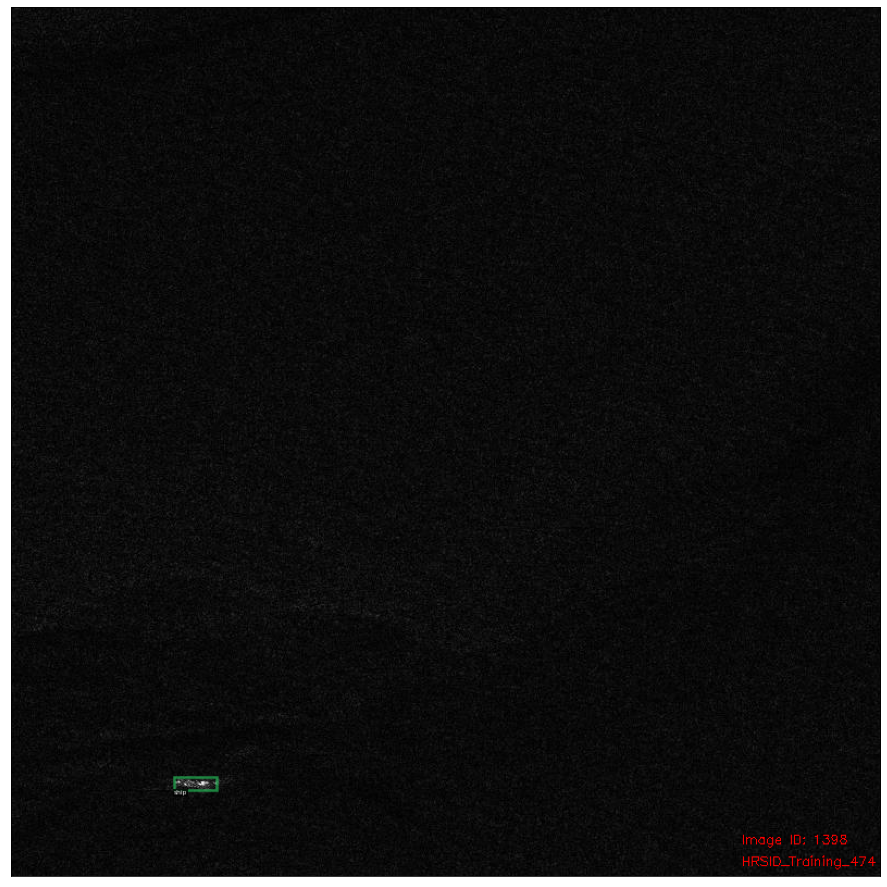

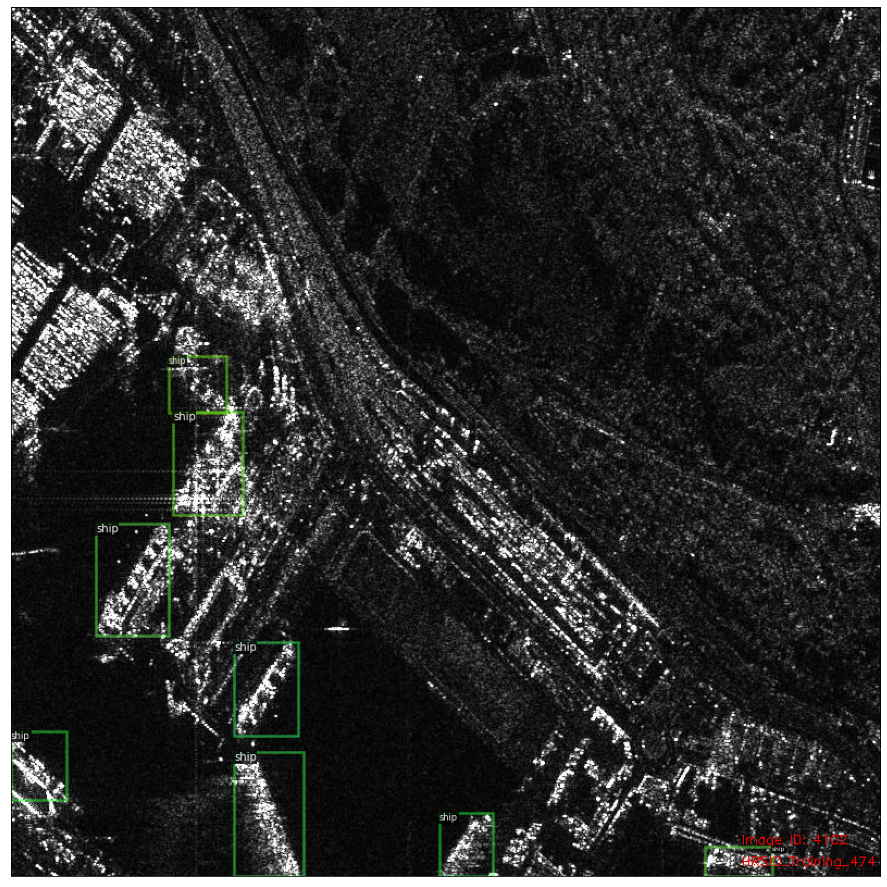

In [13]:
# Show 2 random training images:
for i in range(2): show_rand_img(dicts_train, metadata_train, img_id=None)

# **Gpu memory allocation**

In [14]:
#Gpu memory allocation:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

# **Utils**




In [64]:
def save_config(cfg, file_name):

    """Saves the given configuration in the output and session's directories.

    Args:
        cfg (detectron2.config.config.CfgNode): Model's configuration.
        file_name (str): Name for saving .yaml file.

    """
    # Create the output directory.
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    saving_path = cfg.OUTPUT_DIR + '/' + file_name
    
    #Save configuration to file.
    with open(saving_path, "w") as f:
        f.write(cfg.dump())   
    
    #Copy output configuration in the session's directory.
    !cp $saving_path $file_name
    
    #Check if the given configuration saved successfully.
    test_cfg = get_cfg()
    test_cfg.merge_from_file(file_name)
    if test_cfg:
        print("Model configuration saved successfully!")
        cfg.freeze()
    else: print("Error in model configuration saving")

In [65]:
def datetime_stamp(time_zone :str = 'Europe/Athens'):  
  
    """Creates a datetime stamp based on the given timezone.

    Args:
        time_zone (str): Name of the timezone in which we want the produced 
        date-time stamp.

    Returns: 
        current_date_and_time (str): The current date and time in 
        dd_mm_yyyy__hh_mm format, based on the given timezone.

    """

    timezone = pytz.timezone(time_zone)
    current_date_and_time = datetime.datetime.now(tz=timezone)
    current_date_and_time = current_date_and_time.strftime("%d_%m_%Y__%H_%M")

    return current_date_and_time

# **Custom hooks for validation loss logging during training.**

In [17]:
class LossEvalHook(HookBase):

    '''Custom hook that calculates and prints validation loss 
    in every 20 iterations.

    This class was copied from: https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b
    
    '''

    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

# **Mappers with and without augmentations for training and inference.**

In [18]:
def mapper(dataset_dict):

    '''
    A function that takes a Detectron2's Dataset (list of dictionaries),
    and transforms it into a format that is used by the model.

    This mapper is also responsible for augmenting the training data by using a 
    sequence of photometric and geometric transformations applied on the training 
    images and their corresponding annotations.

    Args:
        dataset_dict (list): Image properties and annotations of the input dataset.

    '''
    
    # Make a copy of the input dict.
    dataset_dict = copy.deepcopy(dataset_dict)

    # Load image.
    image = utils.read_image(dataset_dict["file_name"], format="BGR") # Reads the image based on its filename. HWC image | 0-255 | uint8
    
    # Define a sequence of transformations:
    transformation_list = [T.Resize((1400,1400), interp=PIL.Image.BILINEAR),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomApply(T.RandomBrightness(0.7, 1.2), prob=0.3), 
                      T.RandomApply(T.RandomContrast(0.7, 1.2), prob=0.3),
                      T.RandomApply(T.RandomSaturation(0.7, 1.2), prob=0.3)
                      ]
    
    # Transform image.transforms.ToTensor()(np.array(img))
    auginput = T.AugInput(image) # Define the augmentation input ("image" required, others optional). 
    
    # Transform image.
    auginput, transforms = T.apply_transform_gens(transformation_list, auginput)
    dataset_dict["image"] = torch.as_tensor(copy.deepcopy(auginput.image.transpose(2, 0, 1).astype(dtype=np.uint8))) #dtype=np.uint8 'float32'
    
    # Transform annotations.
    annos = [
        utils.transform_instance_annotations(obj, [transforms], auginput.image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    
    instances = utils.annotations_to_instances(annos, auginput.image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    
    return dataset_dict

In [19]:
def mapper_wo(dataset_dict):
    
    '''
    Mapper without augmentations.
    This mapper is used only for inference.
    
    Args:
        dataset_dict (list): Image properties and annotations of the input dataset.

    '''

    # Make a copy of the input dict.
    dataset_dict = copy.deepcopy(dataset_dict)  
    
    # Load image.
    image = utils.read_image(dataset_dict["file_name"], format="BGR") # Reads the image based on its filename. HWC image | 0-255 | uint8

    # Transform image.
    auginput = T.AugInput(image) # Define the augmentation input ("image" required, others optional). 
    transform = T.Resize((1400, 1400),interp=PIL.Image.BILINEAR)(auginput) #Apply the transformation.
    image = torch.from_numpy(copy.deepcopy(auginput.image.transpose(2, 0, 1)))  #Change channel order from w*h*c to c*w*h

    # Transform annotations.
    annos = [
        transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
        if annotation.get("iscrowd", 0) == 0
    ]

    # Convert annotations to Instances and filter out the empty ones. 
    instances = utils.annotations_to_instances(annos, image.shape[1:])

    # Add image and instances to the dictionary.
    dataset_dict["image"] = image #image[0,:,:]because utils.read_image() uses pillow converts the image from grayscale to bgr with 3 identical channels.
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

In [20]:
def show_original_augmented(dataset_dict, dataset_metadata):

    ''' This function selects a random image with its annotations and displays it 
    side by side with the corresponding augmented image with the new annotations 
    that are extracted from the mapper used in training.

    Args:
        dataset_dict (list): Image properties and annotations of the input dataset.
        dataset_metadata (detectron2.data.Metadata): Metadata of the given set.
    '''

    # Select a random image.
    random_im_number = random.randint(181, len(dataset_dict)) 
    
    # Draw annotations on the original image.
    random_image_4_viz = cv2.imread(dataset_dict[random_im_number]['file_name']) 
    viz = Visualizer(random_image_4_viz, dataset_metadata, scale=1., instance_mode=ColorMode.SEGMENTATION)
    out1 = viz.draw_dataset_dict(dataset_dict[random_im_number])
    shape_min = random_image_4_viz.shape[0]
    number_of_gt_boxes = len(dataset_dict[random_im_number]['annotations'])
    
    # Draw annotations on the augmented image.
    aug_inputs = mapper(dataset_dict[random_im_number])
    random_image_4_viz2 = np.moveaxis(np.array(aug_inputs['image']),0,-1)
    viz = Visualizer(random_image_4_viz2, dataset_metadata, scale=1., instance_mode=ColorMode.SEGMENTATION)
    number_of_new_gt_boxes = len(aug_inputs['instances'])
    out2 = viz.overlay_instances(boxes=aug_inputs['instances'].gt_boxes.tensor.to('cpu'),assigned_colors=['magenta']*number_of_new_gt_boxes)
    shape_max = random_image_4_viz2.shape[0]
    
    # The instance number in original and augmented image must be the same.
    assert number_of_gt_boxes==number_of_new_gt_boxes
    
    # Pad the smaller image (original image) with zeros.
    if shape_max<shape_min: shape_min, shape_max = shape_max, shape_min
    frame_width = int((shape_max - shape_min)/2)
    npad = ((frame_width, frame_width), (frame_width, frame_width), (0, 0))
    out_collage = np.hstack((np.pad(out1.get_image(), npad),out2.get_image()))
    
    # Print image id.
    cv2.putText(
        out_collage, #numpy array on which text is written
        'Image ID: '+  str(dataset_dict[random_im_number]['image_id']), #text
        (int(2*shape_max-shape_max/5), int(0.97*shape_max)), #position at which writing has to start
        cv2.FONT_HERSHEY_SIMPLEX, #font family
        1., #font size
        (255, 0, 0, 0),
        2) #font stroke
    
    # Display the collage.
    plt.figure(figsize=(30,30))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out_collage);

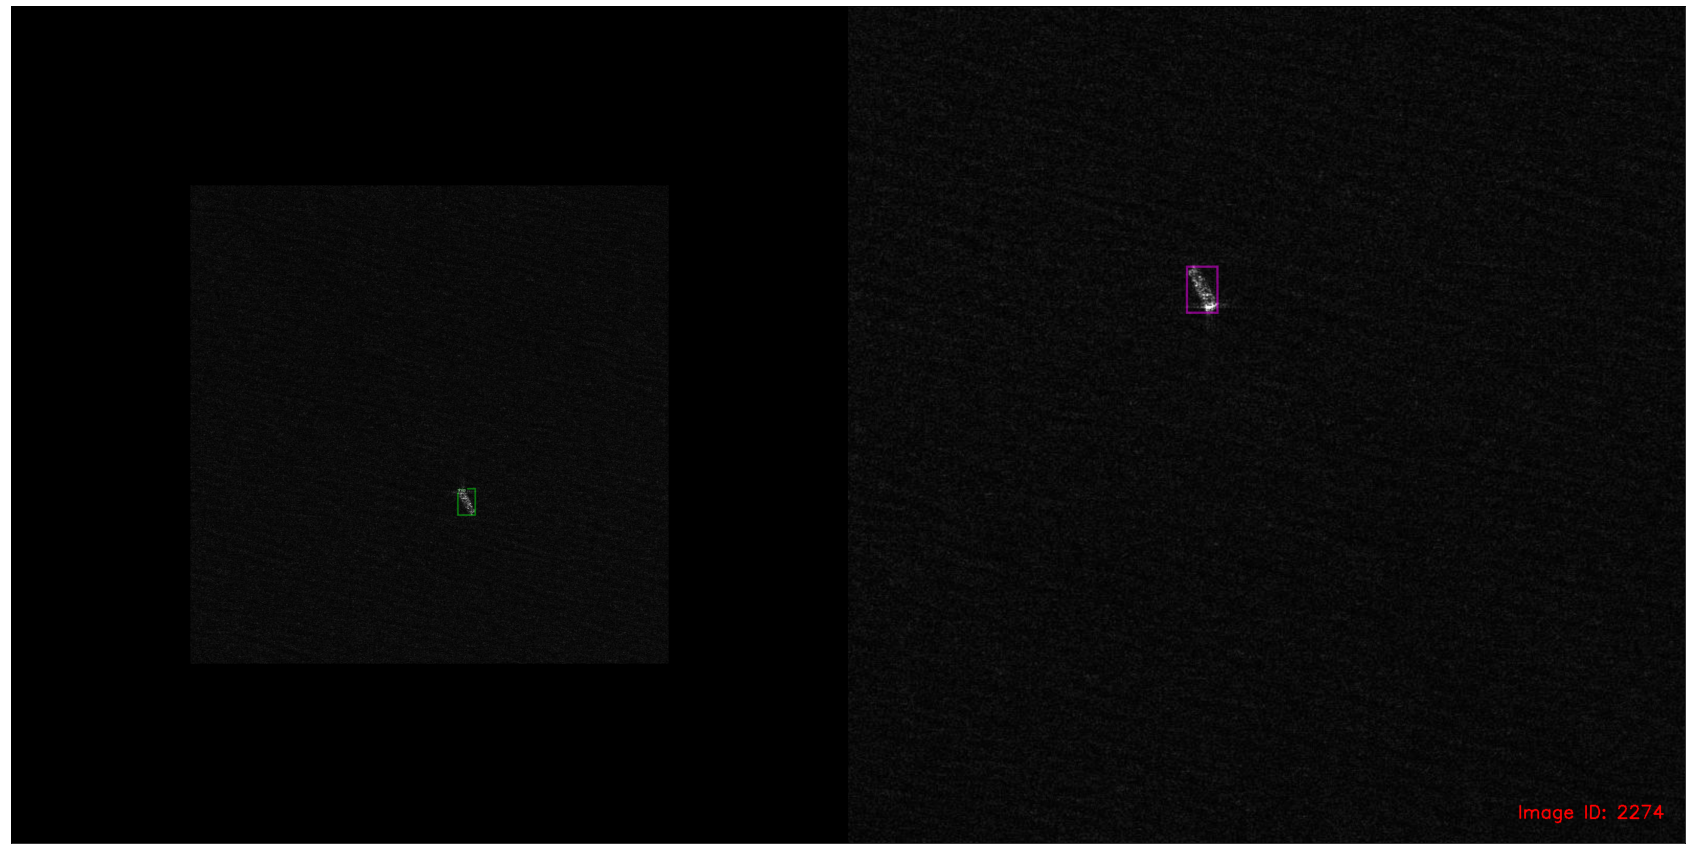

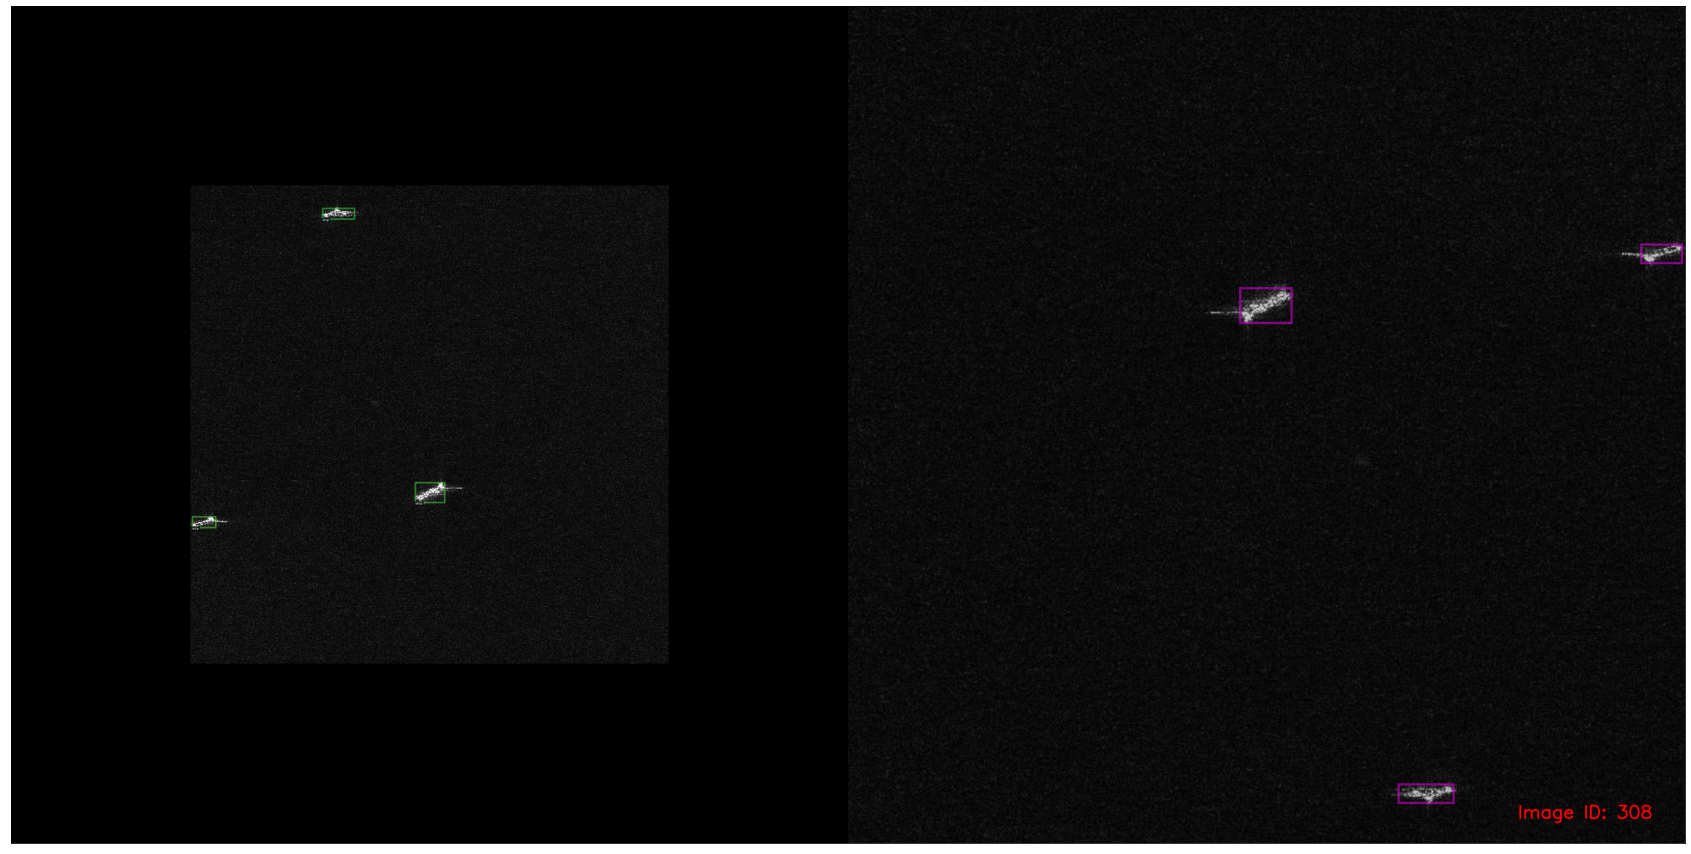

In [21]:
# Show 2 random images with their corresponding augmented ones:
for i in range(2):show_original_augmented(dicts_train, metadata_train) 

# **Configuration**

In [ ]:
assert False #Break the execution here 

In [22]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.SEED = 42

# Define training and validation datasets:
#-------------------------------------------------------------------------------
cfg.DATASETS.TRAIN = (dataset_names[train_id],) 
cfg.DATASETS.TEST = (dataset_names[val_id],) # Validation Data!!!
#-------------------------------------------------------------------------------

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Only one class (ship). 
cfg.MODEL.BACKBONE.FREEZE_AT = 0 # -> All weights are trainable.

# Input properties:
#-------------------------------------------------------------------------------
# Because we created a custom mapper this is not used...
cfg.INPUT.MIN_SIZE_TRAIN = (1400,)
cfg.INPUT.RANDOM_FLIP = "none"
cfg.INPUT.MAX_SIZE_TRAIN = 1400
cfg.INPUT.MIN_SIZE_TEST = 1400 #0 = disable resizing in testing
cfg.INPUT.MAX_SIZE_TEST = 1400
#-------------------------------------------------------------------------------

# Solver properties:
#-------------------------------------------------------------------------------
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MOMENTUM = 0.90
cfg.SOLVER.BASE_LR = 0.005 # base learning rate ~0.0005 if u want to continiue training else 0.005 
cfg.SOLVER.CHECKPOINT_PERIOD = 2000 # Save a checkpoint after every this number of iterations.
cfg.SOLVER.MAX_ITER = 4000
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 500
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
#-------------------------------------------------------------------------------

# Normalization parameters and input format:
#-------------------------------------------------------------------------------
cfg.MODEL.PIXEL_MEAN = [17.467]*3 
cfg.MODEL.PIXEL_STD = [13.975]*3 
cfg.INPUT.FORMAT = "BGR"
#-------------------------------------------------------------------------------

# Define the corresponding anchor box properties for every Pi level.
#-------------------------------------------------------------------------------

cfg.MODEL.RPN.IN_FEATURES = ['p2','p3','p4','p5','p6'] 

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [
                                    [16.174, 24.418, 13.39], # P2
                                    [25.037, 27.657, 28.812], # P3
                                    [43.000, 53.000, 84.000], # P4
                                    [102.000, 176.000, 349.000], # P5
                                    [249.404, 128.570, 668.358] # P6
                                    ] 

cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [
                                            [0.581, 0.272, 1.328], # P2
                                            [1.487, 2.997, 0.272], # P3
                                            [2.030, 0.726, 2.012], # P4
                                            [0.775, 1.269, 0.874], # P5
                                            [0.500, 1.000, 2.000] # P6
                                            ]

cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[0]] # the bounding boxes are 'normal'.
#-------------------------------------------------------------------------------

# Configuration for the nubmer of ROIs before and after the application of NMS.
#-------------------------------------------------------------------------------
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 3000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 3000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 3000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 3000
#-------------------------------------------------------------------------------

# Configuration for validation and testing.
#-------------------------------------------------------------------------------
cfg.TEST.DETECTIONS_PER_IMAGE = 95
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.TEST.EVAL_PERIOD = 250
cfg.TEST.AUG.FLIP = False
#-------------------------------------------------------------------------------

# Define the directory where output files are written.
cfg.OUTPUT_DIR = './' +'_'+ datetime_stamp() 

# Save configuration
config_filename =  'configuration_' + datetime_stamp() + '.yaml'
save_config(cfg,config_filename)

Model configuration saved successfully!


# **Custom trainer with custom mappers and hooks**

In [23]:
class MyTrainer(DefaultTrainer):

    '''Trainer that is based on the 'DefaultTrainer' class but with some 
    extra customizations regarding its default methods.'''
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper) #mapper with augmentations 
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=mapper_wo) #mapper without augmentations 
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
             
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                mapper=mapper
            )
        ))
        return hooks

In [ ]:
import wandb
personal_wandb_api_key = ''
wandb.login(key=personal_wandb_api_key)

wandb: Currently logged in as: jasonman (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **Log training data in Weights & Biases.**

In [ ]:
# Train the model (one run without sweeps)
wandb.init(mode="disabled") #close wandb session if its running

# Start wandb session.
project_name = "FasterRCNN" 
entity_name = "jasonman"
wandb.init(project=project_name, entity=entity_name, sync_tensorboard=True) 

# Start training.
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# After training we must terminate wandb session.
wandb.init(mode="disabled") 

In [ ]:
# In colab u can see the training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir cfg.OUTPUT_DIR

# **Train the model with sweeps**

In [24]:
# Define the search method for hyperparameter sweeps.
sweep_config = {'method': 'random'}

# Define the target metric and add it to the configuration.
metric = {'name': 'bbox/AP50', 'goal': 'maximize'}
sweep_config['metric'] = metric

# Set the hyperparameters for tuning and the coresponding search range.
parameters_dict = {

    'momentum': {
    'values': [0.9, 0.95, 0.99]},
    'anchor_sizes': {
    'values': [cfg.MODEL.ANCHOR_GENERATOR.SIZES]},
    'anchor_ratios': {
    'values': [cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS]},
    'IOU_thresholds': {
    'values': [[0.2], [0.3], [0.4], [0.5]]}, 
    'pre_NMS_top_train': {
    'values': [1000, 2000, 3000, 4000, 5000]},
    'post_NMS_top_train': {
    'values': [1000, 2000, 3000]},
    'pre_NMS_top_test': {
    'values': [1000, 2000, 3000, 4000, 5000]},
    'post_NMS_top_test': {
    'values': [1000, 2000, 3000]},
    'learning_rate':{'value': cfg.SOLVER.BASE_LR}
}

# Add parameters dictionary to sweep configuration.
sweep_config['parameters'] = parameters_dict

# If u want to add new configuration parameters:
parameters_dict.update({'epochs': {'value': 6}})
parameters_dict.update({'batch_size': {'values': [2,4]}})  

In [25]:
sweep_config

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'bbox/AP50'},
 'parameters': {'IOU_thresholds': {'values': [[0.2], [0.3], [0.4], [0.5]]},
  'anchor_ratios': {'values': [[[0.581, 0.272, 1.328],
     [1.487, 2.997, 0.272],
     [2.03, 0.726, 2.012],
     [0.775, 1.269, 0.874],
     [0.5, 1.0, 2.0]]]},
  'anchor_sizes': {'values': [[[16.174, 24.418, 13.39],
     [25.037, 27.657, 28.812],
     [43.0, 53.0, 84.0],
     [102.0, 176.0, 349.0],
     [249.404, 128.57, 668.358]]]},
  'batch_size': {'values': [2, 4]},
  'epochs': {'value': 6},
  'learning_rate': {'value': 0.005},
  'momentum': {'values': [0.9, 0.95, 0.99]},
  'post_NMS_top_test': {'values': [1000, 2000, 3000]},
  'post_NMS_top_train': {'values': [1000, 2000, 3000]},
  'pre_NMS_top_test': {'values': [1000, 2000, 3000, 4000, 5000]},
  'pre_NMS_top_train': {'values': [1000, 2000, 3000, 4000, 5000]}}}

In [71]:
def sweeptrain(cfg):

    '''This function changes the model's configuration parameters according to
    the extracted parameter from the sweep configuration. Every time that this function
    is called, it defines a new model that is trained with a new set of hyperparameters. 
    
    Args:
        cfg (detectron2.config.config.CfgNode): Base configuration of the model.
    '''
    
    # Start wandb session.
    wandb.init(project="FasterRCNN", entity="jasonman", sync_tensorboard=True)
    
    number_of_epochs_2_train = 6
    number_of_training_imgs = 3461
    
    # Change configuration according to sweep cofig values.
    cfg.defrost()
    cfg.SOLVER.IMS_PER_BATCH = wandb.config.batch_size
    cfg.SOLVER.BASE_LR  = wandb.config.learning_rate
    cfg.SOLVER.MOMENTUM = wandb.config.momentum
    cfg.SOLVER.MAX_ITER = round(number_of_epochs_2_train*number_of_training_imgs/wandb.config.batch_size)
    cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = wandb.config.IOU_thresholds
    cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = wandb.config.pre_NMS_top_train
    cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = wandb.config.post_NMS_top_train
  
    # Create a new trainer based on the previous configuration parameters.
    trainer = MyTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    
    # Start training when the function is called..
    return trainer.train()

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="FasterRCNN") # run this when u are changing sweep configuration.
# sweep_id = 'gj021nte' if u want to continiue experiments using an older swep config.
wandb.agent(project="FasterRCNN", sweep_id = sweep_id, function= lambda:sweeptrain(cfg), count=1)
wandb.init(mode="disabled")

In [ ]:
# In colab u can see the training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

# **Plots**

In [49]:
# experiment_folder = cfg.OUTPUT_DIR 
experiment_folder = '/content'

def load_json_arr(json_path):

    '''Auxiliary function that transforms the input .json file to a list of dicts.

    Args:
        json_path (str): Output folder that was used during training.
    '''

    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

def plot_train_val_loss(experiment_folder):

    '''Plots total and validation losses based on the "metrics.json" file generated
    in training. The total (training) loss is calculated every 20 iterations (default
    step in detectron2 library for loss calculation) and validation loss is calculated 
    every cfg.TEST.EVAL_PERIOD iterations.

    Args:
        experiment_folder (str): Output folder that was used during training.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

    plt.figure(figsize=(16,8))

    # Plot total loss.
    plt.plot(
        [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
        [x['total_loss'] for x in experiment_metrics if 'total_loss' in x],
        label="total_loss")
    
    # Plot validation loss curve.
    xs = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
    ys = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]
    if ys!=[]: plt.plot(xs, ys, c='red', label="validation_loss")
    
    # Plot validation loss points.
    plt.scatter(xs, ys, marker='*', zorder=10, c='black')

    # Plot labels.
    for x_pos, y_pos in zip(xs, ys):
        label = str(round(y_pos,3))
        while (len(label)<5): label += '0'
        plt.text(x_pos, y_pos+0.05, s=label)
    
    # Plot properties
    plt.legend(loc='upper right')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()

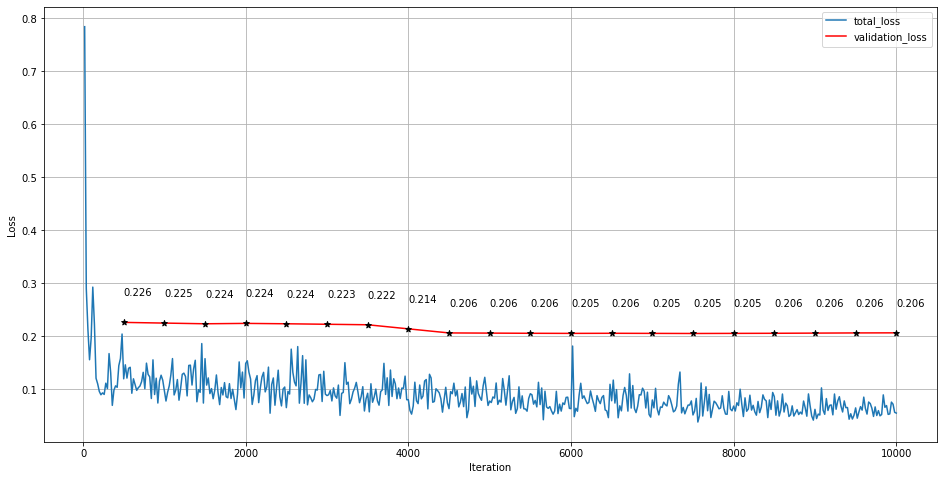

In [50]:
plot_train_val_loss(experiment_folder)

In [45]:
def plot_all_losses(experiment_folder, y_log_scale=True, trendlines=True):

    '''Plots the 4 different losses (RPN+ROI Heads) of the Faster-RCNN network 
    based on the "metrics.json" file. 

    Args:
        experiment_folder (str): Output folder that was used during training.
        y_log_scale (bool): If y-axis is in log scale. 
        trendlines (bool): Plot the corresponding polynomial trendlines of the losses. 
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
    plt.figure(figsize=(16,8))
    
    losses = ["loss_box_reg", "loss_cls", "loss_rpn_cls", "loss_rpn_loc"]

    # Plot loss.
    for loss in losses: 

        # Plot original line.      
        xs = [x['iteration'] for x in experiment_metrics if loss in x]
        ys = [x[loss] for x in experiment_metrics if loss in x]
        order = np.argsort(xs)
        p = plt.plot(xs, ys, "-", label=loss, linewidth = 1)
        
        if trendlines:

            # Plot polynomial trendline.
            z = np.polyfit(np.array(xs)[order.astype(int)], 
                     np.array(ys)[order.astype(int)], 2)
            poly = np.poly1d(z)
            plt.plot(np.array(xs)[order.astype(int)], 
                     poly(np.array(xs)[order.astype(int)]), 
                     color = p[0].get_color(), linewidth=1.5)

    # Plot properties
    plt.legend(loc='upper right')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    if y_log_scale: plt.yscale('log') 
    plt.grid()

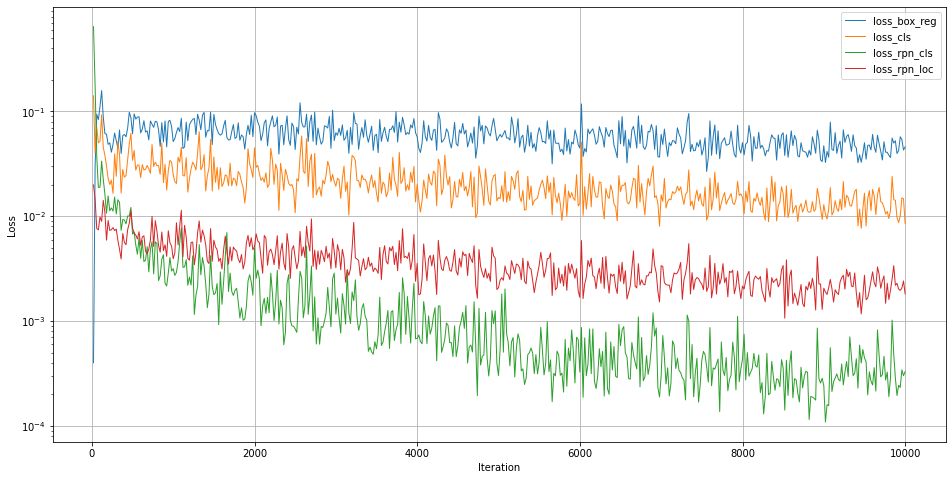

In [46]:
plot_all_losses(experiment_folder, True, False)

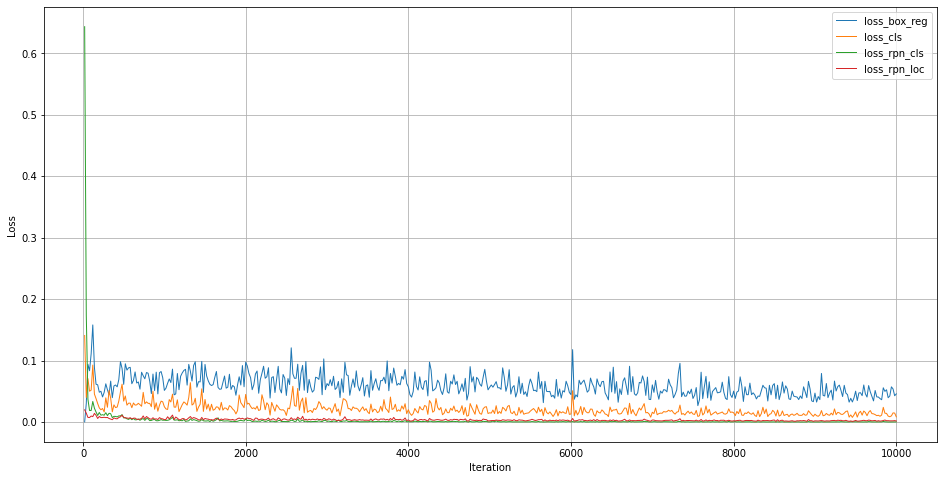

In [47]:
plot_all_losses(experiment_folder, False, False)

In [42]:
def plot_other_info(experiment_folder):

    '''Plots foreground/ backround accuracy, number of foreground and backround
    samples as well as the numbers of positive and negative anchors existing in a
    batch. 

    Args:
        experiment_folder (str): Output folder that was used during training.
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
    
    mtrics = ["fast_rcnn/cls_accuracy", 
              "fast_rcnn/false_negative", 
              "fast_rcnn/fg_cls_accuracy",  
              "roi_head/num_bg_samples", 
              "roi_head/num_fg_samples", 
              "rpn/num_neg_anchors", 
              "rpn/num_pos_anchors"]

    # Plots.
    fig, ax1 = plt.subplots(figsize=(16,8))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    cmaplist = plt.get_cmap('Dark2').colors

    for i, mtric in enumerate(mtrics):

        xs = [x['iteration'] for x in experiment_metrics if mtric in x]
        ys = [x[mtric] for x in experiment_metrics if mtric in x]

        # Label properties.
        mean = np.array(ys).mean()
        label = str(round(mean, 3))
        
        # Select in which axis you want to plot each metric.
        if mtric in mtrics[:3]:
            p = ax1.plot(xs, ys, label=mtric, color = cmaplist[i], linewidth=1)
            text_color = p[0].get_color()
            ax1.text(np.array(xs).mean()+500*i, mean, s=label, color=text_color, zorder=6,  
                     size=14, path_effects=[pe.withStroke(linewidth=2, foreground="black")])
        else:
            p = ax2.plot(xs, ys, label=mtric, color = cmaplist[i], linewidth=1)    
            text_color = p[0].get_color()
            ax2.text(np.array(xs).mean()+500*i, mean, s=label, color=text_color, zorder=6, 
                     size=14, path_effects=[pe.withStroke(linewidth=1, foreground="black")])   

    # Axis properties
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('FG+BG Accuracy')
    ax2.set_ylabel('Number of FG+BG Samples and Positive/Negative Anchors')
    ax1.grid()

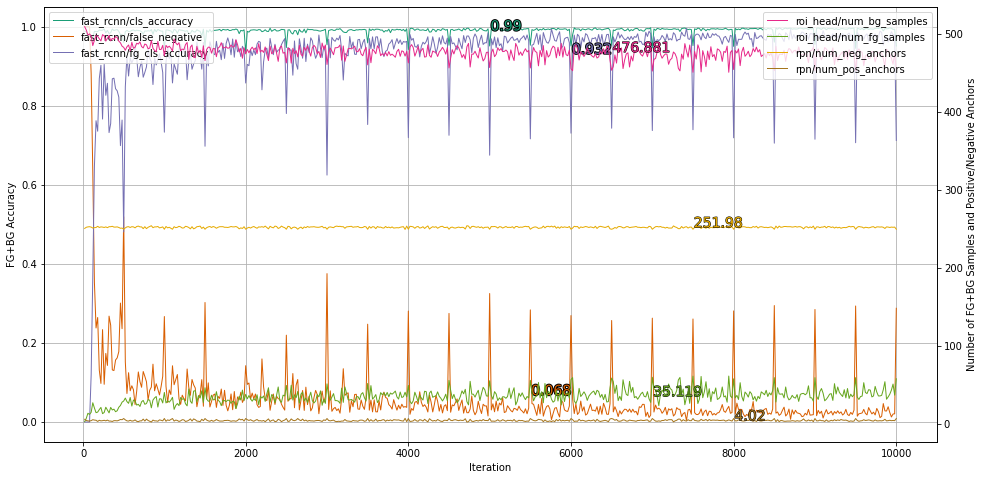

In [51]:
plot_other_info(experiment_folder)

In [72]:
def plot_APs(experiment_folder, labels=True):

    '''Plots Average Precision values for different object sizes and values of 
    the Jaccard index which are calculated in every cfg.TEST.EVAL_PERIOD iterations.

    Args:
        experiment_folder (str): Output folder that was used during training.
        labels (bool): Show AP values. 
    '''

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
    plt.figure(figsize=(16,8))

    AP_types = ["bbox/AP", "bbox/AP50", "bbox/AP75", "bbox/APl", "bbox/APm", "bbox/APs"]

    for AP_type in AP_types:

        # Plot AP curve.
        xs = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
        ys = [x[AP_type] for x in experiment_metrics if AP_type in x]
        if len(xs)<len(ys):
            xs.append(xs[-1]+250)
        plt.plot(xs, ys, label=AP_type, linewidth=2)
        
        # Plot AP points.
        plt.scatter(xs, ys, marker='*', zorder=3, c='black', s=10)

        # Plot labels.
        if labels:
            for i, (x_pos, y_pos) in enumerate(zip(xs, ys)):
                label = str(round(y_pos,3))
                if i%5 ==0: # plot every 5 steps
                    while (len(label)<5): label += '0'
                    plt.text(x_pos, y_pos+0.005, s=label, fontsize=9, zorder=4,
                    path_effects=[pe.withStroke(linewidth=3, foreground="white")])
    
    # Plot properties
    plt.legend(loc='upper left')
    plt.xlabel('Iteration')
    plt.ylabel('AP')
    plt.grid()

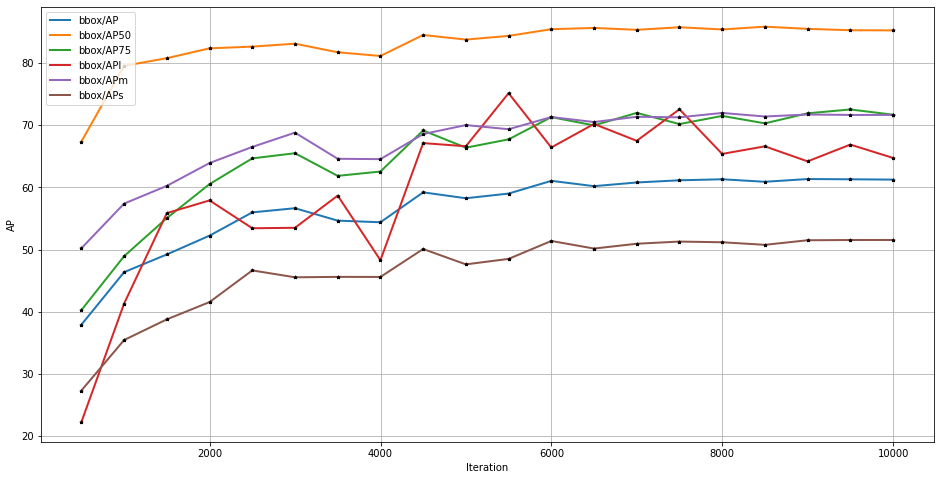

In [53]:
plot_APs(experiment_folder, False)

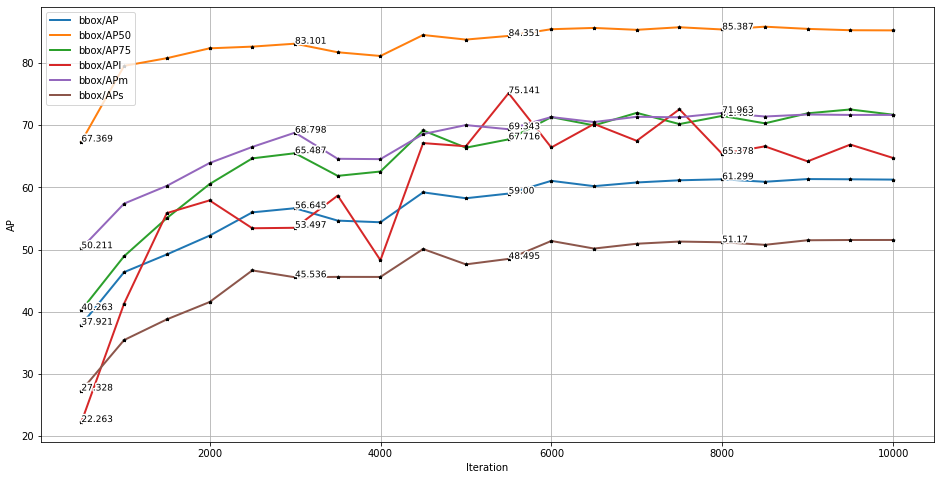

In [54]:
plot_APs(experiment_folder, True)

# **Download results**

## Kaggle

In [ ]:
# Output training files:
directory_path = cfg.OUTPUT_DIR
%cd $directory_path
!ls

In [ ]:
# Zip the above folder to ex.zip
%cd /kaggle/working
!zip -r ex.zip $cfg.OUTPUT_DIR

## Colab

In [ ]:
# Zip output folder
!zip -r experiments.zip $cfg.OUTPUT_DIR

# Download the results
from google.colab import files
files.download('experiments.zip')

# Quantitative Evaluation

In [ ]:
# Load model's configuration
cfg_path = '/content/drive/MyDrive/FINAL_MODELS/FRCNN_normal/configuration_07_02_2022__12_59.yaml' #'./configuration_07_02_2022__12_59.yaml'
cfg = get_cfg()
cfg.merge_from_file(cfg_path)

# Change some configuration properties
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/FINAL_MODELS/FRCNN_normal/model_final.pth' #cfg.OUTPUT_DIR + '/' + 'model_final.pth' # loads trained weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 3000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 3000
cfg.DATASETS.TRAIN = (dataset_names[train_id],) 
cfg.DATASETS.TEST = (dataset_names[val_id],) 
cfg.OUTPUT_DIR = '/content' #define the directory that contains the metrics.json file generated during training.

# Build the model from configuration file and MyTrainer():
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=True)
model = trainer.model # has the same result as detectron2.modeling.build_model but it does not load weights! We must use before cfg.MODEL.WEIGHTS = ...

# Buld evaluator and data loader. 
evaluator = COCOEvaluator(dataset_names[test_id], output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, dataset_names[test_id], mapper_wo)

# Evaluate:
print(inference_on_dataset(model, val_loader, evaluator))

[03/26 12:39:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Qualitative Evaluation

## Inference on images.

In [55]:
# Load and change some configuration parameters:
cfg_path = '/content/drive/MyDrive/FINAL_MODELS/FRCNN_normal/configuration_07_02_2022__12_59.yaml' #'./configuration_07_02_2022__12_59.yaml'
cfg = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.defrost()
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/FINAL_MODELS/FRCNN_normal/model_final.pth'          #cfg.OUTPUT_DIR + '/' + 'model_final.pth'
cfg.DATASETS.TRAIN = (dataset_names[train_id],) 
cfg.DATASETS.TEST = (dataset_names[val_id],)   
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold

In [74]:
def show_results(noi_2_display, dataset_dicts, dataset_metadata, cfg):

    """Shows a given number of images (>=2) with their predictions/annotations.

    Args:
        noi_2_display (int): Number of images to display.
        dataset_dicts (list): Input dataset's dicts.
        dataset_metadata (detectron2.data.Catalog.Metadata): Input dataset's metadata.
        cfg (detectron2.config.config.CfgNode): Model's configuration.
    """
    
    noi_2_display = int(noi_2_display)
    if noi_2_display%2 !=0: noi_2_display += 1 

    # Number of images on each row/column
    imgs_4_display_in_side = 2 
    if noi_2_display%5==0: imgs_4_display_in_side = 5 
    if (noi_2_display>=8 and imgs_4_display_in_side!=5): imgs_4_display_in_side = 4 
    image_rows = int(noi_2_display/imgs_4_display_in_side)

    predictor = DefaultPredictor(cfg) 

    for i,d in enumerate(random.sample(dataset_dicts, noi_2_display)):    
        temp_val_image = cv2.imread(d["file_name"]) # read a random image

        # Predict amd draw instances in the above random image.
        outputs = predictor(temp_val_image)  
        v = Visualizer(temp_val_image, metadata=dataset_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        # Extract input image's shape.
        image_shape = out.get_image().shape
        
        # Initialization of ndarrays.
        if i==0:
            stacked_images = np.zeros(shape=out.get_image().shape+(noi_2_display,))
            rows = np.zeros(shape=(image_shape[0], # height
                                    image_shape[1]*imgs_4_display_in_side, # width
                                    image_shape[2], # number of channels 
                                    noi_2_display)) 
        
        # Put text and stack the above annotated image into an ndarray.  
        annotated_image = out.get_image()  

        cv2.putText(annotated_image, 'Image ID: ' +  str(d['image_id']),
                    (int(0.75*image_shape[1]), int(0.95*image_shape[0])), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255, 0), 1) 
        
        stacked_images[:,:,:,i] = annotated_image
    
    # Create one row at a time.
    for i in range(image_rows):
        rows[:,:,:,i] = np.hstack([stacked_images[:,:,:,hor_number]
                                  for hor_number in range(i*imgs_4_display_in_side, 
                                                          i*imgs_4_display_in_side+
                                                          imgs_4_display_in_side)])
    
    # Stich all rows together.
    collage = np.vstack([rows[:,:,:,i] for i in range(image_rows)])
    
    # Show results.
    plt.figure(figsize=(30, 15))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.uint8(collage))

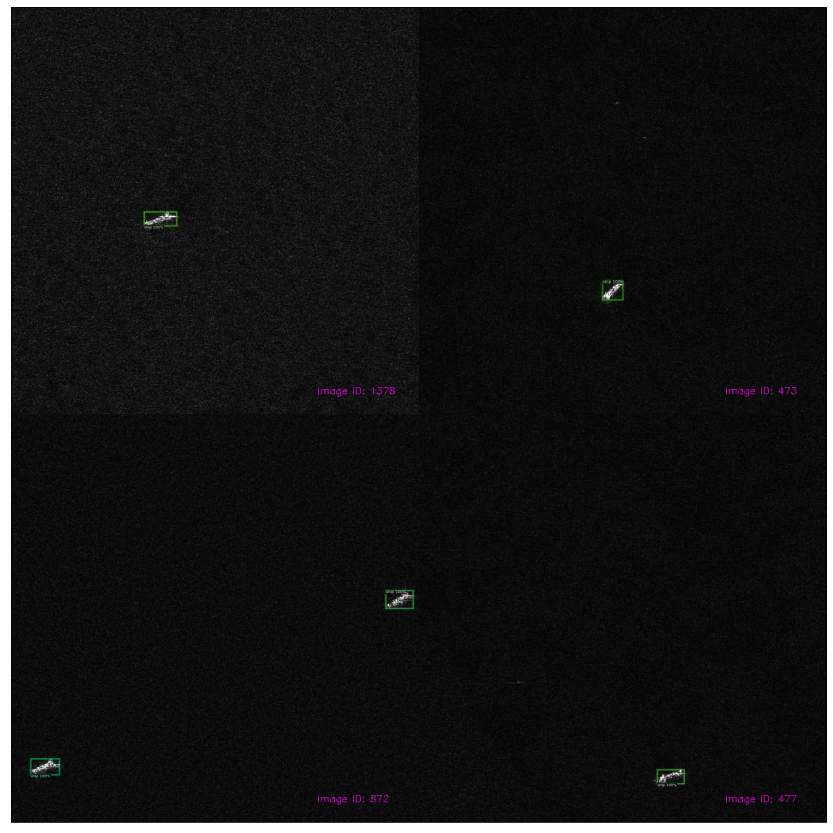

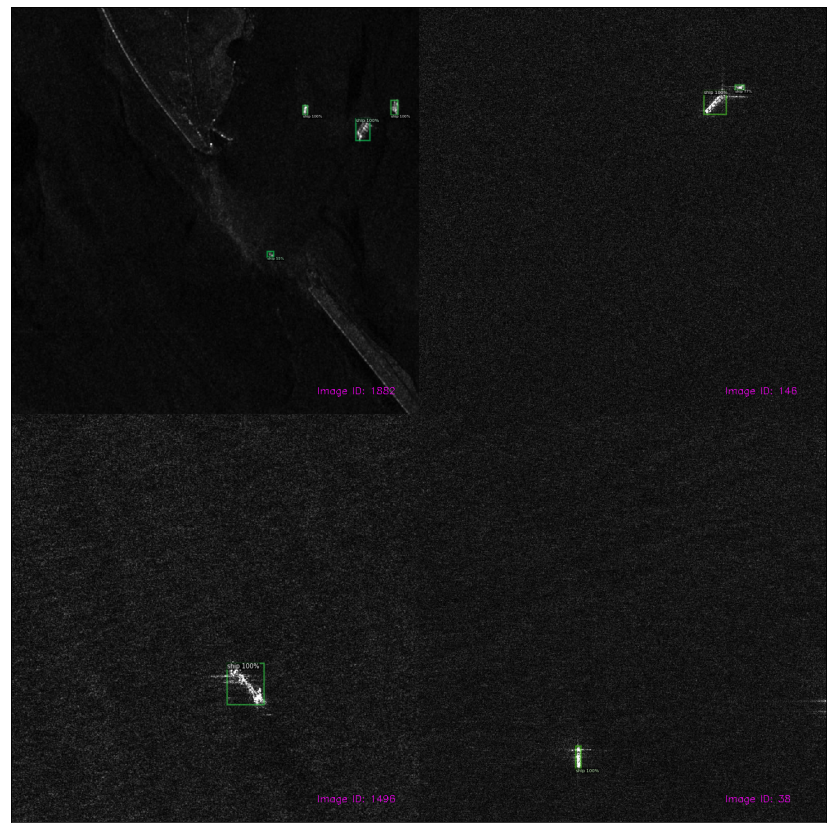

In [76]:
noi_2_display = 4 #number of images for displaying.
for i in range(2): show_results(noi_2_display, dicts_test, metadata_test, cfg)

## Inference on video.

In [ ]:
#Clone detectron2's repository from github.
!git clone https://github.com/facebookresearch/detectron2

In [ ]:
# Load model's configuration:
cfg_path = '/content/drive/MyDrive/FINAL_MODELS/FRCNN_normal/configuration_07_02_2022__12_59.yaml' 
cfg = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.defrost()
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/FINAL_MODELS/FRCNN_normal/model_final.pth'       

In [ ]:
# Run frame-by-frame inference demo on this video with the "demo.py" tool provided in the detectron2's repository.
%run detectron2/demo/demo.py \
  --config-file $cfg_path \
  --video-input Base_vid.wmv --confidence-threshold 0.25 --output video-output.mkv \
  --opts MODEL.WEIGHTS $cfg.MODEL.WEIGHTS

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')